  <td>
    <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/>
  </td>


# DataRow Metadata Guide

## Overview

We are launching a new feature called DataRow Metadata. Metadata is being developed to help users better understand their data to help with labeling, model diagnostics, and data selection. This **should not be confused with attachements** formerly called metadata. Attachments provides additional context for labelers but is not searchable within Catalog.

The metadata feature is in beta and aspect are subject change. During the Beta data must metadata must be uploaded to ***reserved fields*** defined by Labelbox. In the near future we will support user defined ***custom fields***. THe current available fields are:

* **tag**: a free text field
* **split**: enum of train-valid-test
* **captureDateTime**: ISO 8601 datetime field. All times must be in UTC
* **embedding**: A 128 length list 32 bit floats used for similarity search. All datarows share the same similarity index.

### Installation

You must install a `3.0.0` release or above of the SDK

In [ ]:
!pip install -q --upgrade tensorflow-hub \
                 scikit-learn \
                 seaborn \
                 "labelbox[data]"

## Setup

In [ ]:
import labelbox
import random
import numpy as np
from labelbox.schema.data_row_metadata import (
    DataRowMetadata,
    DataRowMetadataField,
    DeleteDataRowMetadata,
)
from sklearn.random_projection import GaussianRandomProjection
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
from datetime import datetime
from tqdm.notebook import tqdm
import requests
from pprint import pprint

In [ ]:
API_KEY = None
client = labelbox.Client(api_key=API_KEY)

## Metadata ontology

We use a similar system for managing metadata as we do feature schemas. Metadata scheams are strongly typed to ensure we can provide the best experience in the App. Each metadata field can be uniquely accessed by id. Names are unique within the kind of metadata, reserved or custom.

Metadata fields support a couple of core kinds:

* **Enum**: A classification with options, only one option can be selected at a time
* **DateTime**: A utc ISO datetime 
* **Embedding**: 128 float 32 vector used for similarity
* **String**: A string of less than 500 characters

In [ ]:
mdo = client.get_data_row_metadata_ontology()

In [ ]:
# dictionary access with id
pprint(mdo.fields_by_id, indent=2)

In [ ]:
# access by name
split_field = mdo.reserved_by_name["split"]
train_field = mdo.reserved_by_name["split"]["train"]

In [ ]:
tag_field = mdo.reserved_by_name["tag"]

In [ ]:
tag_field

## Setup embeddings/similarity

The quality of embeddings is based on how well a machine learning model overlaps with your task. An off the shelf model will perform much worse then a model you have trained yourself.

Here we use a [TensorfFlow Hub](https://tfhub.dev) model trained on Imagenet to create embeddings and then run a dimensionality reduction step to match the Labelbox requirements

In [ ]:
TFHUB_MODEL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2" #@param {type:"string"}

In [ ]:
def make_file_processor(height, width):
    
  def decode_image(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return img

  def process_file(bytez):
    img = decode_image(bytez)
    img = tf.image.resize(img, [height, width])
    return img[tf.newaxis, ...]

  return process_file

INPUT_HEIGHT, INPUT_WIDTH = 224, 224
SIMILARITY_DIMENSION = 128
model = hub.KerasLayer(TFHUB_MODEL)
processor = make_file_processor(INPUT_HEIGHT, INPUT_WIDTH)

## Uploading metadata

As mentioned previously metadata is strongly typed. To upload metadata for a datarow you construct a `DataRowMetadata` object which contains the fields `DataRowMetadataField` to put on the datarow. To construct a metadata field you must provide the schema id for the field and value that will be uploaded. Metadata will overwrite on a per field basis. 




In [ ]:
field = DataRowMetadataField(
    schema_id=mdo.reserved_by_name["captureDateTime"].uid,  # specify the schema id
    value=datetime.now(), # typed inputs
)
# Completed object ready for upload
DataRowMetadata(
    data_row_id="my-datarow-id",
    fields=[
            field
    ]
)

### Building up uploads

In [ ]:
# Select a dataset to use
dataset_id = None
dataset = client.get_dataset(dataset_id)

In [ ]:
# train-valid-test break down
test = 0.05
valid = 0.05 + test
train = 1 - valid

In [ ]:
uploads = []
embeddings = []

for datarow in tqdm(dataset.export_data_rows(), total=dataset.row_count):
    
    response = requests.get(datarow.row_data, stream=True)

    # assign datarows a split
    rnd = random.random()
    if rnd < test:
        split = mdo.reserved_by_name["split"]["test"]
    elif rnd < valid:
        split = mdo.reserved_by_name["split"]["valid"]
    else:
        split = mdo.reserved_by_name["split"]["train"]
    
    embeddings.append(list(model(processor(response.content), training=False)[0].numpy()))
    dt = datetime.utcnow() 
    message ="my-new-message"

    uploads.append(
        DataRowMetadata(
            data_row_id=datarow.uid,
            fields=[
                DataRowMetadataField(
                    schema_id=mdo.reserved_by_name["captureDateTime"].uid,
                    value=dt,
                ),
                DataRowMetadataField(
                    schema_id=split.parent,
                    value=split.uid
                ),
                DataRowMetadataField(
                    schema_id=mdo.reserved_by_name["tag"].uid,
                        value=message
                ),
            ]
        )
    )

### Reduce dimensionality

Labelbox supports dimensions of length 128 so we use a [Gaussian Random Projection](https://scikit-learn.org/stable/modules/random_projection.html#gaussian-random-projection) to project the data from 1024 into a compatible size

In [ ]:
gaussian_projected = GaussianRandomProjection(n_components=2).fit_transform(np.vstack(embeddings))

In [ ]:
sns.scatterplot(x=gaussian_projected[:, 0], y=gaussian_projected[:, 1])
sns.despine()

In [ ]:
# project to 128 and add to upload
projected = GaussianRandomProjection(n_components=SIMILARITY_DIMENSION, random_state=42).fit_transform(np.vstack(embeddings))
for md, embd in zip(uploads, projected):
    md.fields.append(
        DataRowMetadataField(
            schema_id=mdo.reserved_by_name["embedding"].uid,
            value=embd.tolist(), # convert from numpy to list
        ),
    )

### Upload

In [ ]:
mdo.bulk_upsert(uploads)

## Accessing Metadata

Currently there is no option for exporting metadata in bulk. We will be working to support that functionality in the near future.

In [ ]:
datarow = next(dataset.data_rows())

### Similarity

To access similarity navigate to the datarow page or within a dataset or catalog and toggle the drop down on the left 

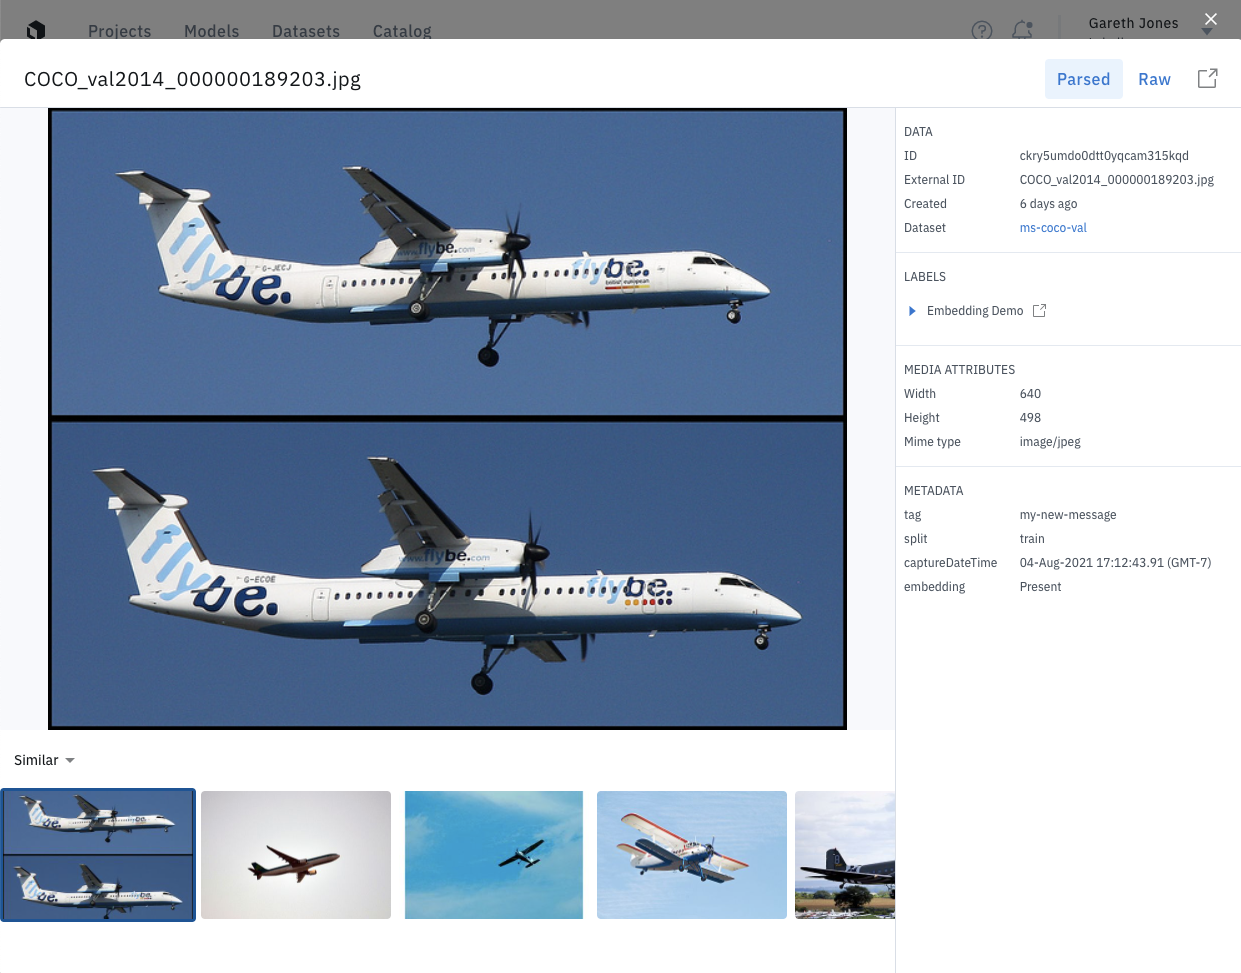



In [ ]:
# datarow page
print(f'https://app.labelbox.com/datarows/{datarow.uid}')

In [ ]:
metadata = mdo.bulk_export([datarow.uid])[0]

## Delete Metadata

To delete fields from a datarow you provide the schema ids you want removed 

**Note** for enums you must currently pass the Enum and Option schema ids

In [ ]:
md = uploads[0]

In [ ]:
fields = []
# iterate through the fields you want to delete
for field in md.fields:
    fields.append(field.schema_id)

deletes = DeleteDataRowMetadata(
    data_row_id=md.data_row_id,
    fields=fields
)

In [ ]:
len(mdo.bulk_export(deletes.data_row_id)[0].fields)

In [ ]:
mdo.bulk_delete([deletes])

In [ ]:
len(mdo.bulk_export(deletes.data_row_id)[0].fields)

### Tell us more about the features you want [here](https://portal.productboard.com/t8t5vu6cutoerk4wsskkpyzr)